# Ultra functionalized code with non-linearity (add more layers to model)
Completely using fast.ai/pytorch libraries and python classes.

In [1]:
from fastai.vision.all import *

/home/gg/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Preparing dataset

In [2]:
full_dataset_dir = untar_data(URLs.MNIST)

In [3]:
image_size=28*28 # np.prod(array(Image.open(Path.ls(full_dataset_dir/'training/3/')[0])).shape)

In [4]:
numbers= [3,7] #range(0,10)

In [5]:
def load_mnist(top_dir='testing'):
    full_dataset=[]
    labels=[]
    for number in numbers:
        path = Path.ls(full_dataset_dir/'{}/{}/'.format(top_dir,number))
        im_tensor = [ tensor(Image.open(p)) for p in path ]
        for i in range(0,len(im_tensor)): # otherwise it would simply be a list of lists
            full_dataset.append(im_tensor[i])
            labels.append(number)
    x_stack = (torch.stack(full_dataset).float()/255).view(-1,image_size)
    y_stack = tensor(labels).unsqueeze(1)
    del full_dataset,labels
    return x_stack, y_stack    

In [6]:
train_x_stack,train_y_stack= load_mnist('training')
test_x_stack,test_y_stack= load_mnist('testing')

In [7]:
train_x_stack.shape, train_y_stack.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [8]:
test_y_stack.shape, test_y_stack.shape

(torch.Size([2038, 1]), torch.Size([2038, 1]))

Assign 1 for 3s and 0 for 7s.

In [9]:
train_y_stack = (train_y_stack == 3) * 1

In [10]:
test_y_stack = (test_y_stack == 3) * 1

In [11]:
train_dset = list(zip(train_x_stack,train_y_stack))
test_dset = list(zip(test_x_stack,test_y_stack))
dl = DataLoader(train_dset,batch_size=256) # train in batches for each epoch
test_dl = DataLoader(test_dset,batch_size=256) # train in batches for each epoch
dls = DataLoaders(dl,test_dl)

# Define Loss function

In [12]:
def sigmoid(x) : return 1/(1+torch.exp(-x))

def mnist_loss(predictions,targets):
    predictions=sigmoid(predictions)
    return torch.where(targets==1,1-predictions,predictions).mean()

# Define non-Linear model using pytorch with 30 activations

This model is a simple function that does this:
```
def simple_net(x):
    res = x@w1 + b1 #linear layer
    res = res.max(tensor(0.0)) #ReLU , non-linearity
    res = res@w2 + b2 #linear layer
    return res
```

In [13]:
init_params = lambda size,std=1: (torch.randn(size)*std).requires_grad_()

In [14]:
w1=init_params((image_size,30)) # 30 activations
b1 = init_params(30)
w2=init_params((30,1))
b2 = init_params(1)

The above simple_net function can be replaced with the following using pytorch.

**Initializing weights for each layer** and eveything else will be done by pytorch.

In [27]:
simple_net = nn.Sequential(
                nn.Linear(image_size,30),
                nn.ReLU(),
                nn.Linear(30,1))

Can make different combinations and layers. Just make sure the next layer has correct number of activations.

In [29]:
list(simple_net.parameters())

[Parameter containing:
 tensor([[ 0.0211,  0.0085,  0.0322,  ...,  0.0185, -0.0190,  0.0068],
         [-0.0328, -0.0055, -0.0090,  ...,  0.0004,  0.0251,  0.0014],
         [-0.0104,  0.0016, -0.0258,  ...,  0.0248,  0.0001,  0.0303],
         ...,
         [ 0.0013, -0.0248, -0.0063,  ...,  0.0142, -0.0308,  0.0073],
         [ 0.0085,  0.0207,  0.0103,  ...,  0.0168,  0.0316, -0.0213],
         [ 0.0252,  0.0223, -0.0002,  ...,  0.0298, -0.0347,  0.0222]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0069,  0.0236,  0.0335, -0.0195,  0.0254,  0.0098,  0.0020, -0.0161,
         -0.0295, -0.0065,  0.0327,  0.0026, -0.0284,  0.0191,  0.0030, -0.0351,
          0.0142, -0.0349, -0.0076,  0.0034,  0.0079,  0.0349, -0.0162, -0.0300,
         -0.0171,  0.0063, -0.0183, -0.0235, -0.0232,  0.0302],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0341, -0.0540,  0.0395, -0.1358, -0.0415,  0.0763,  0.0982,  0.0063,
          -0.0952, -0.1562, -0.1216,  0.180

# Validation loop

In [17]:
# check for each batch if 3 or 7 and check it with the label
def batch_accuracy(x,y):
    preds=x.sigmoid()
    correct = (preds>0.5) == y
    return correct.float().mean()

# Fastai method to do the training bit using `dls`

**SGD manages the grad part. Learner manages the training part and checking with test set**

In [30]:
learn = Learner(dls, model=simple_net, opt_func=SGD, lr = 0.1, loss_func = mnist_loss, metrics= batch_accuracy)

In [31]:
learn.fit(40)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.329496,0.406720,0.507851,00:00
1,0.150327,0.229124,0.803729,00:00
2,0.082516,0.112755,0.915604,00:00
3,0.054085,0.075836,0.941609,00:00
4,0.041048,0.059399,0.959764,00:00
5,0.034379,0.050332,0.964181,00:00
6,0.030538,0.044659,0.964671,00:00
7,0.028048,0.040797,0.965653,00:00
8,0.026259,0.037989,0.968597,00:00
9,0.024870,0.035851,0.970069,00:00


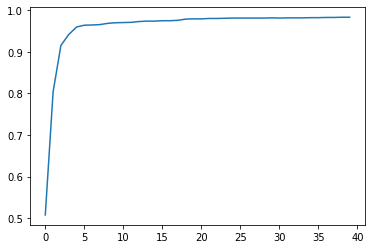

In [33]:
plt.plot(L(learn.recorder.values).itemgot(2))